In [10]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import math
import time

In [ ]:
dataArima = pd.read_parquet('Data/agg_table_new_zones8Bot.parquet')
#The already binned and aggregated dataset


In [ ]:
#Preparing the data for the ARIMA and creating a pivot table to predict for all 139 zones
dataArima['time_bin'] = pd.to_datetime(dataArima['time_bin'])
pivot_data = dataArima.pivot_table(index='time_bin', columns='h3_index', values='order_count', fill_value=0)

In [13]:
#As there were some time bins without a value and not in the table we have to fill it with zeros
start_time_full = pivot_data.index.min()
end_time_full = pivot_data.index.max()
full_index_all_zones = pd.date_range(start=start_time_full, end=end_time_full, freq='15min')
pivot_data = pivot_data.reindex(full_index_all_zones, fill_value=0)

In [14]:
#We use fourier features to recreate seasonal patterns with the help of sin and cos waves
def create_fourier_features(index, seasonal_period, k):
    n_samples = len(index)
    time = np.arange(n_samples)
    features = {}
    for i in range(1, k + 1):
        features[f'sin_{i}'] = np.sin(2 * np.pi * i * time / seasonal_period)
        features[f'cos_{i}'] = np.cos(2 * np.pi * i * time / seasonal_period)
    return pd.DataFrame(features, index=index)

In [15]:
seasonal_period = 96 #(24*4) One day 
k = 12 #High value of fourier features to learn spikes
pdq_order = (2, 0, 1) # (p, d, q) with d=0 (AR) (I) (MA)
all_fourier_features = create_fourier_features(pivot_data.index, seasonal_period, k) # Preparation of the exogene variables with the data set
split_point_idx = int(len(pivot_data) * 0.875) #We use only test and train split as we don't need to validate. The value is unobserved by the model
results = {}

# Each 48 the values are refitted
refit_interval = 48

# preparing loop
total_zones = len(pivot_data.columns)
start_time_total = time.time()

In [ ]:
#We are going zone by zone to determine the values
for i, zone_id in enumerate(pivot_data.columns):
    print(f'\n--- Working on Zone {i+1}/{total_zones}: {zone_id} ---')
    zone_series = pivot_data[zone_id]
    zone_series_log = np.log1p(zone_series)

    # Train/Test Split for this zone
    train_endog_zone = zone_series_log.iloc[:split_point_idx]
    test_endog_zone = zone_series_log.iloc[split_point_idx:]
    test_actual_zone = zone_series.iloc[split_point_idx:]

    train_exog_zone = all_fourier_features.iloc[:split_point_idx]
    test_exog_zone = all_fourier_features.iloc[split_point_idx:]

    # We use a walk forward for the training by using the variables
    history_endog = train_endog_zone.copy() # endogene variables (log)
    history_exog = train_exog_zone.copy() # exogene variables
    predictions_log_zone = [] # List of log predictions for this zone
    current_model_fit = None # Platzhalter für das aktuell gültige Modell
    zone_start_time = time.time()

    for t in range(len(test_endog_zone)):
        if t % refit_interval == 0 or current_model_fit is None:
            # Train model with history data during refit interval
            model = SARIMAX(endog=history_endog,
                            exog=history_exog,
                            order=pdq_order,
                            seasonal_order=(0, 0, 0, 0))
            
            try:
                # We enforce stationarity, by letting it on standard true
                #Maxiter is the max number of iterations
                current_model_fit = model.fit(disp=False, maxiter=200, method='lbfgs') #lbfgs is our optimization model
            except Exception as e:
                print(f'Error refitting zone {zone_id} at step {t+1}: {e}')
                # Fallback: If refit fails
                if current_model_fit is None:
                     print(f'Termination because of this zone here: {zone_id}')
                     predictions_log_zone = [np.nan] * len(test_endog_zone)
                     break # Next zone

        # Predictions with actual model
        try:
            exog_next_step = test_exog_zone.iloc[[t]] # Prepare exogenes for next step
            yhat_log = current_model_fit.forecast(steps=1, exog=exog_next_step)  # Predict one step
            predictions_log_zone.append(yhat_log.iloc[0])  #Extract value
        except Exception as e:
             print(f'Error predicting {zone_id} at step {t+1}: {e}')
             if predictions_log_zone:
                 predictions_log_zone.append(predictions_log_zone[-1])
             else:
                 predictions_log_zone.append(np.nan)

        # Add observation to next step
        obs_log = test_endog_zone.iloc[[t]]
        history_endog = pd.concat([history_endog, obs_log]) # Endog extended
        history_exog = pd.concat([history_exog, test_exog_zone.iloc[[t]]]) # Exog extended

    zone_end_time = time.time()
    #Calculate metrics for each zone
    if len(predictions_log_zone) == len(test_actual_zone):
        predictions_zone = np.expm1(np.array(predictions_log_zone))
        predictions_zone[predictions_zone < 0] = 0

        mae = mean_absolute_error(test_actual_zone, predictions_zone)
        mse = mean_squared_error(test_actual_zone, predictions_zone)
        rmse = math.sqrt(mse)
        r2 = r2_score(test_actual_zone, predictions_zone)

        nonzero_indices = test_actual_zone != 0
        actual_vals = test_actual_zone.values
        forecast_vals = predictions_zone

        if np.any(nonzero_indices):#for zero division
            mape = np.mean(np.abs((actual_vals[nonzero_indices] - forecast_vals[nonzero_indices]) / actual_vals[nonzero_indices])) * 100
        else:
            mape = np.nan
    else: #If it breaks
        mae, mse, rmse, r2, mape = [np.nan] * 5
        predictions_zone = np.full(len(test_actual_zone), np.nan)


    results[zone_id] = {
        'predictions': predictions_zone,
        'actual': test_actual_zone.values,
        'mae': mae,
        'rmse': rmse,
        'r2': r2,
        'mape': mape
    }
    print(f'Zone {zone_id} - RMSE: {rmse:.2f}, R2: {r2:.4f}')


total_end_time = time.time()


--- Working on Zone 1/139: 88329b430dfffff ---
Zone 88329b430dfffff - RMSE: 0.23, R2: 0.0807

--- Working on Zone 2/139: 88329b4325fffff ---
Zone 88329b4325fffff - RMSE: 0.01, R2: 0.0000

--- Working on Zone 3/139: 88329b432dfffff ---


c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Zone 88329b432dfffff - RMSE: 0.56, R2: 0.1365

--- Working on Zone 4/139: 88329b4343fffff ---


c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA param

Zone 88329b4343fffff - RMSE: 0.17, R2: 0.0222

--- Working on Zone 5/139: 88329b4345fffff ---
Zone 88329b4345fffff - RMSE: 0.40, R2: 0.0550

--- Working on Zone 6/139: 88329b4361fffff ---
Zone 88329b4361fffff - RMSE: 1.14, R2: 0.3848

--- Working on Zone 7/139: 88329b4363fffff ---


c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA param

Zone 88329b4363fffff - RMSE: 0.29, R2: -0.1049

--- Working on Zone 8/139: 88329b4365fffff ---


c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA param

Zone 88329b4365fffff - RMSE: 0.25, R2: 0.1119

--- Working on Zone 9/139: 88329b4369fffff ---


c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA param

Zone 88329b4369fffff - RMSE: 0.40, R2: 0.2436

--- Working on Zone 10/139: 88329b436dfffff ---
Zone 88329b436dfffff - RMSE: 1.58, R2: 0.6742

--- Working on Zone 11/139: 88329b4a49fffff ---


c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA param

Zone 88329b4a49fffff - RMSE: 0.14, R2: -0.0257

--- Working on Zone 12/139: 88329b5101fffff ---
Zone 88329b5101fffff - RMSE: 1.28, R2: 0.6992

--- Working on Zone 13/139: 88329b5105fffff ---


c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA param

Zone 88329b5105fffff - RMSE: 0.35, R2: 0.4024

--- Working on Zone 14/139: 88329b5109fffff ---
Zone 88329b5109fffff - RMSE: 3.03, R2: 0.8602

--- Working on Zone 15/139: 88329b510bfffff ---
Zone 88329b510bfffff - RMSE: 0.73, R2: 0.3999

--- Working on Zone 16/139: 88329b510dfffff ---


c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Zone 88329b510dfffff - RMSE: 0.86, R2: 0.4272

--- Working on Zone 17/139: 88329b5143fffff ---
Zone 88329b5143fffff - RMSE: 4.23, R2: 0.8722

--- Working on Zone 18/139: 88329b5147fffff ---


c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Zone 88329b5147fffff - RMSE: 1.99, R2: 0.7291

--- Working on Zone 19/139: 88329b514bfffff ---
Zone 88329b514bfffff - RMSE: 0.34, R2: 0.0788

--- Working on Zone 20/139: 88329b5151fffff ---
Zone 88329b5151fffff - RMSE: 0.02, R2: 0.0000

--- Working on Zone 21/139: 88329b5155fffff ---


c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Zone 88329b5155fffff - RMSE: 1.54, R2: 0.5879

--- Working on Zone 22/139: 88329b516bfffff ---


c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Zone 88329b516bfffff - RMSE: 0.51, R2: 0.2726

--- Working on Zone 23/139: 88329b5801fffff ---


c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Zone 88329b5801fffff - RMSE: 1.93, R2: 0.8453

--- Working on Zone 24/139: 88329b5805fffff ---


c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Zone 88329b5805fffff - RMSE: 6.36, R2: 0.7982

--- Working on Zone 25/139: 88329b5807fffff ---
Zone 88329b5807fffff - RMSE: 0.44, R2: 0.3076

--- Working on Zone 26/139: 88329b5809fffff ---
Zone 88329b5809fffff - RMSE: 0.94, R2: 0.2098

--- Working on Zone 27/139: 88329b580bfffff ---
Zone 88329b580bfffff - RMSE: 1.82, R2: 0.3003

--- Working on Zone 28/139: 88329b580dfffff ---
Zone 88329b580dfffff - RMSE: 0.58, R2: 0.6084

--- Working on Zone 29/139: 88329b5811fffff ---
Zone 88329b5811fffff - RMSE: 2.67, R2: 0.8116

--- Working on Zone 30/139: 88329b5813fffff ---
Zone 88329b5813fffff - RMSE: 2.92, R2: 0.8959

--- Working on Zone 31/139: 88329b5815fffff ---


c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Zone 88329b5815fffff - RMSE: 0.90, R2: 0.1504

--- Working on Zone 32/139: 88329b5817fffff ---
Zone 88329b5817fffff - RMSE: 3.18, R2: 0.8732

--- Working on Zone 33/139: 88329b5819fffff ---
Zone 88329b5819fffff - RMSE: 3.77, R2: 0.8910

--- Working on Zone 34/139: 88329b581bfffff ---


c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Zone 88329b581bfffff - RMSE: 2.34, R2: 0.7361

--- Working on Zone 35/139: 88329b581dfffff ---
Zone 88329b581dfffff - RMSE: 1.99, R2: 0.8025

--- Working on Zone 36/139: 88329b5829fffff ---


c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA param

Zone 88329b5829fffff - RMSE: 0.27, R2: -0.0847

--- Working on Zone 37/139: 88329b5831fffff ---
Zone 88329b5831fffff - RMSE: 0.10, R2: 0.0025

--- Working on Zone 38/139: 88329b5835fffff ---
Zone 88329b5835fffff - RMSE: 0.53, R2: 0.2789

--- Working on Zone 39/139: 88329b5839fffff ---


c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA param

Zone 88329b5839fffff - RMSE: 1.03, R2: 0.1927

--- Working on Zone 40/139: 88329b583bfffff ---


c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA param

Zone 88329b583bfffff - RMSE: 0.40, R2: 0.3825

--- Working on Zone 41/139: 88329b5851fffff ---


c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Zone 88329b5851fffff - RMSE: 1.94, R2: 0.6296

--- Working on Zone 42/139: 88329b5853fffff ---
Zone 88329b5853fffff - RMSE: 2.76, R2: 0.7611

--- Working on Zone 43/139: 88329b5855fffff ---
Zone 88329b5855fffff - RMSE: 0.60, R2: 0.4874

--- Working on Zone 44/139: 88329b5857fffff ---
Zone 88329b5857fffff - RMSE: 4.13, R2: 0.9225

--- Working on Zone 45/139: 88329b5859fffff ---


c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Zone 88329b5859fffff - RMSE: 1.25, R2: 0.6296

--- Working on Zone 46/139: 88329b585bfffff ---


c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Zone 88329b585bfffff - RMSE: 2.33, R2: 0.5315

--- Working on Zone 47/139: 88329b585dfffff ---


c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Zone 88329b585dfffff - RMSE: 0.49, R2: 0.0709

--- Working on Zone 48/139: 88329b5863fffff ---


c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Zone 88329b5863fffff - RMSE: 6.75, R2: 0.9247

--- Working on Zone 49/139: 88329b586bfffff ---
Zone 88329b586bfffff - RMSE: 0.49, R2: 0.4037

--- Working on Zone 50/139: 88329b5881fffff ---


c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Zone 88329b5881fffff - RMSE: 2.24, R2: 0.7267

--- Working on Zone 51/139: 88329b5883fffff ---
Zone 88329b5883fffff - RMSE: 4.59, R2: 0.8912

--- Working on Zone 52/139: 88329b5885fffff ---


c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Zone 88329b5885fffff - RMSE: 1.62, R2: 0.5884

--- Working on Zone 53/139: 88329b5887fffff ---


c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Zone 88329b5887fffff - RMSE: 1.31, R2: 0.7944

--- Working on Zone 54/139: 88329b5889fffff ---


c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Zone 88329b5889fffff - RMSE: 4.80, R2: 0.9644

--- Working on Zone 55/139: 88329b588bfffff ---


c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Zone 88329b588bfffff - RMSE: 3.47, R2: 0.8209

--- Working on Zone 56/139: 88329b588dfffff ---


c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Zone 88329b588dfffff - RMSE: 11.32, R2: 0.9196

--- Working on Zone 57/139: 88329b5895fffff ---
Zone 88329b5895fffff - RMSE: 3.87, R2: 0.8801

--- Working on Zone 58/139: 88329b589dfffff ---
Zone 88329b589dfffff - RMSE: 2.67, R2: 0.6677

--- Working on Zone 59/139: 88329b58a1fffff ---
Zone 88329b58a1fffff - RMSE: 0.80, R2: 0.5282

--- Working on Zone 60/139: 88329b58a3fffff ---
Zone 88329b58a3fffff - RMSE: 1.33, R2: 0.6630

--- Working on Zone 61/139: 88329b58a9fffff ---


c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA param

Zone 88329b58a9fffff - RMSE: 0.67, R2: 0.4235

--- Working on Zone 62/139: 88329b58abfffff ---


c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Zone 88329b58abfffff - RMSE: 0.82, R2: 0.2850

--- Working on Zone 63/139: 88329b58adfffff ---
Zone 88329b58adfffff - RMSE: 0.56, R2: 0.1213

--- Working on Zone 64/139: 88329b58b1fffff ---


c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Zone 88329b58b1fffff - RMSE: 0.70, R2: 0.2937

--- Working on Zone 65/139: 88329b58b3fffff ---
Zone 88329b58b3fffff - RMSE: 1.69, R2: 0.7850

--- Working on Zone 66/139: 88329b58b9fffff ---


c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Zone 88329b58b9fffff - RMSE: 1.99, R2: 0.8317

--- Working on Zone 67/139: 88329b58bbfffff ---


c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Zone 88329b58bbfffff - RMSE: 0.73, R2: 0.3995

--- Working on Zone 68/139: 88329b58bdfffff ---
Zone 88329b58bdfffff - RMSE: 6.17, R2: 0.8919

--- Working on Zone 69/139: 88329b58c1fffff ---


c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Zone 88329b58c1fffff - RMSE: 2.62, R2: 0.7685

--- Working on Zone 70/139: 88329b58c3fffff ---


c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Zone 88329b58c3fffff - RMSE: 5.50, R2: 0.9167

--- Working on Zone 71/139: 88329b58c5fffff ---


c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Zone 88329b58c5fffff - RMSE: 3.46, R2: 0.8278

--- Working on Zone 72/139: 88329b58c7fffff ---
Zone 88329b58c7fffff - RMSE: 3.88, R2: 0.7815

--- Working on Zone 73/139: 88329b58c9fffff ---
Zone 88329b58c9fffff - RMSE: 0.76, R2: 0.2147

--- Working on Zone 74/139: 88329b58cbfffff ---
Zone 88329b58cbfffff - RMSE: 8.01, R2: 0.9054

--- Working on Zone 75/139: 88329b58cdfffff ---
Zone 88329b58cdfffff - RMSE: 4.05, R2: 0.9028

--- Working on Zone 76/139: 88329b58d1fffff ---


c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Zone 88329b58d1fffff - RMSE: 2.10, R2: 0.6764

--- Working on Zone 77/139: 88329b58d3fffff ---


c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA param

Zone 88329b58d3fffff - RMSE: 0.76, R2: 0.2545

--- Working on Zone 78/139: 88329b58d5fffff ---
Zone 88329b58d5fffff - RMSE: 3.61, R2: 0.8924

--- Working on Zone 79/139: 88329b58d7fffff ---
Zone 88329b58d7fffff - RMSE: 2.19, R2: 0.8538

--- Working on Zone 80/139: 88329b58d9fffff ---


c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Zone 88329b58d9fffff - RMSE: 2.47, R2: 0.5542

--- Working on Zone 81/139: 88329b58dbfffff ---
Zone 88329b58dbfffff - RMSE: 0.80, R2: 0.2832

--- Working on Zone 82/139: 88329b58ddfffff ---


c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Zone 88329b58ddfffff - RMSE: 2.17, R2: 0.8251

--- Working on Zone 83/139: 88329b58e1fffff ---


c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Zone 88329b58e1fffff - RMSE: 4.99, R2: 0.8828

--- Working on Zone 84/139: 88329b58e3fffff ---


c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Zone 88329b58e3fffff - RMSE: 5.72, R2: 0.8296

--- Working on Zone 85/139: 88329b58e5fffff ---
Zone 88329b58e5fffff - RMSE: 1.81, R2: 0.5548

--- Working on Zone 86/139: 88329b58e7fffff ---
Zone 88329b58e7fffff - RMSE: 0.93, R2: 0.5958

--- Working on Zone 87/139: 88329b58e9fffff ---


c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Zone 88329b58e9fffff - RMSE: 4.73, R2: 0.6946

--- Working on Zone 88/139: 88329b58ebfffff ---
Zone 88329b58ebfffff - RMSE: 4.86, R2: 0.9097

--- Working on Zone 89/139: 88329b58edfffff ---
Zone 88329b58edfffff - RMSE: 2.88, R2: 0.8184

--- Working on Zone 90/139: 88329b59d3fffff ---
Zone 88329b59d3fffff - RMSE: 0.09, R2: 0.1464

--- Working on Zone 91/139: 88329b59d7fffff ---
Zone 88329b59d7fffff - RMSE: 0.21, R2: 0.0000

--- Working on Zone 92/139: 88329b59dbfffff ---


c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Zone 88329b59dbfffff - RMSE: 1.77, R2: 0.7271

--- Working on Zone 93/139: 88329b5a15fffff ---
Zone 88329b5a15fffff - RMSE: 0.10, R2: -0.0159

--- Working on Zone 94/139: 88329b5a31fffff ---


c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA param

Zone 88329b5a31fffff - RMSE: 0.36, R2: 0.0949

--- Working on Zone 95/139: 88329b5a33fffff ---
Zone 88329b5a33fffff - RMSE: 0.17, R2: 0.2344

--- Working on Zone 96/139: 88329b5a81fffff ---


c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Zone 88329b5a81fffff - RMSE: 2.14, R2: 0.7068

--- Working on Zone 97/139: 88329b5a83fffff ---


c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Zone 88329b5a83fffff - RMSE: 1.19, R2: 0.4682

--- Working on Zone 98/139: 88329b5a85fffff ---


c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Zone 88329b5a85fffff - RMSE: 1.47, R2: 0.7286

--- Working on Zone 99/139: 88329b5a87fffff ---
Zone 88329b5a87fffff - RMSE: 4.96, R2: 0.8729

--- Working on Zone 100/139: 88329b5a89fffff ---


c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA param

Zone 88329b5a89fffff - RMSE: 0.93, R2: 0.2493

--- Working on Zone 101/139: 88329b5a8bfffff ---
Zone 88329b5a8bfffff - RMSE: 0.85, R2: 0.2422

--- Working on Zone 102/139: 88329b5a8dfffff ---


c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA param

Zone 88329b5a8dfffff - RMSE: 0.63, R2: 0.4884

--- Working on Zone 103/139: 88329b5a91fffff ---


c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Zone 88329b5a91fffff - RMSE: 0.43, R2: -0.2347

--- Working on Zone 104/139: 88329b5a93fffff ---


c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Zone 88329b5a93fffff - RMSE: 0.23, R2: -0.0386

--- Working on Zone 105/139: 88329b5a95fffff ---


c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Zone 88329b5a95fffff - RMSE: 0.94, R2: 0.4252

--- Working on Zone 106/139: 88329b5a97fffff ---


c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Zone 88329b5a97fffff - RMSE: 1.81, R2: 0.7185

--- Working on Zone 107/139: 88329b5a9dfffff ---


c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Zone 88329b5a9dfffff - RMSE: 0.20, R2: 0.0297

--- Working on Zone 108/139: 88329b5aa1fffff ---


c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Zone 88329b5aa1fffff - RMSE: 9.10, R2: 0.9520

--- Working on Zone 109/139: 88329b5aa3fffff ---


c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Zone 88329b5aa3fffff - RMSE: 5.59, R2: 0.8722

--- Working on Zone 110/139: 88329b5aa5fffff ---
Zone 88329b5aa5fffff - RMSE: 5.61, R2: 0.9520

--- Working on Zone 111/139: 88329b5aa7fffff ---
Zone 88329b5aa7fffff - RMSE: 5.63, R2: 0.9146

--- Working on Zone 112/139: 88329b5aa9fffff ---
Zone 88329b5aa9fffff - RMSE: 2.53, R2: 0.7885

--- Working on Zone 113/139: 88329b5aabfffff ---


c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Zone 88329b5aabfffff - RMSE: 3.48, R2: 0.9082

--- Working on Zone 114/139: 88329b5aadfffff ---
Zone 88329b5aadfffff - RMSE: 2.84, R2: 0.8566

--- Working on Zone 115/139: 88329b5ab1fffff ---
Zone 88329b5ab1fffff - RMSE: 2.74, R2: 0.7397

--- Working on Zone 116/139: 88329b5ab3fffff ---


c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Zone 88329b5ab3fffff - RMSE: 2.72, R2: 0.7558

--- Working on Zone 117/139: 88329b5ab5fffff ---
Zone 88329b5ab5fffff - RMSE: 5.89, R2: 0.9119

--- Working on Zone 118/139: 88329b5ab7fffff ---


c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Zone 88329b5ab7fffff - RMSE: 4.56, R2: 0.8637

--- Working on Zone 119/139: 88329b5ab9fffff ---
Zone 88329b5ab9fffff - RMSE: 1.12, R2: 0.4263

--- Working on Zone 120/139: 88329b5abbfffff ---
Zone 88329b5abbfffff - RMSE: 4.08, R2: 0.6973

--- Working on Zone 121/139: 88329b5abdfffff ---
Zone 88329b5abdfffff - RMSE: 3.52, R2: 0.9338

--- Working on Zone 122/139: 88329b5ac1fffff ---


c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA param

Zone 88329b5ac1fffff - RMSE: 0.41, R2: 0.0504

--- Working on Zone 123/139: 88329b5ac5fffff ---
Zone 88329b5ac5fffff - RMSE: 0.22, R2: 0.0052

--- Working on Zone 124/139: 88329b5ac7fffff ---


c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Zone 88329b5ac7fffff - RMSE: 0.87, R2: 0.4337

--- Working on Zone 125/139: 88329b5ac9fffff ---


c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Zone 88329b5ac9fffff - RMSE: 0.01, R2: 0.0000

--- Working on Zone 126/139: 88329b5acbfffff ---
Zone 88329b5acbfffff - RMSE: 1.63, R2: 0.8142

--- Working on Zone 127/139: 88329b5acdfffff ---
Zone 88329b5acdfffff - RMSE: 0.15, R2: -0.0312

--- Working on Zone 128/139: 88329b5ad1fffff ---
Zone 88329b5ad1fffff - RMSE: 0.41, R2: 0.1244

--- Working on Zone 129/139: 88329b5ad3fffff ---


c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA param

Zone 88329b5ad3fffff - RMSE: 0.50, R2: 0.1600

--- Working on Zone 130/139: 88329b5ad5fffff ---


c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Zone 88329b5ad5fffff - RMSE: 0.97, R2: 0.2402

--- Working on Zone 131/139: 88329b5ad7fffff ---


c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Zone 88329b5ad7fffff - RMSE: 0.94, R2: 0.1919

--- Working on Zone 132/139: 88329b5adbfffff ---


c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Zone 88329b5adbfffff - RMSE: 2.51, R2: 0.7935

--- Working on Zone 133/139: 88329b5addfffff ---


c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Zone 88329b5addfffff - RMSE: 0.69, R2: 0.5147

--- Working on Zone 134/139: 88329b5ae1fffff ---
Zone 88329b5ae1fffff - RMSE: 0.20, R2: -0.0187

--- Working on Zone 135/139: 88329b5ae3fffff ---
Zone 88329b5ae3fffff - RMSE: 1.16, R2: 0.8078

--- Working on Zone 136/139: 88329b5ae5fffff ---


c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA param

Zone 88329b5ae5fffff - RMSE: 0.40, R2: 0.1161

--- Working on Zone 137/139: 88329b5ae7fffff ---


c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Zone 88329b5ae7fffff - RMSE: 2.81, R2: 0.6760

--- Working on Zone 138/139: 88329b5ae9fffff ---


c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA param

Zone 88329b5ae9fffff - RMSE: 0.67, R2: 0.0573

--- Working on Zone 139/139: 88329b5aebfffff ---


c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\freud\anaconda3\envs\tf310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Zone 88329b5aebfffff - RMSE: 1.29, R2: 0.6697


In [ ]:
#Calculate NRMSE
for zone_id, res in results.items():
    if 'rmse' in res and 'actual' in res and not np.isnan(res['rmse']):
        actual_vals = res['actual']
        rmse = res['rmse']

        mean_actual = np.mean(actual_vals)
        nrmse = (rmse / mean_actual) * 100 if mean_actual != 0 else np.nan 
        results[zone_id]['nrmse'] = nrmse
    else:
        results[zone_id]['nrmse'] = np.nan
#Calculate the averages of all 139 zones
avg_rmse = np.nanmean([res['rmse'] for res in results.values()])
avg_r2 = np.nanmean([res['r2'] for res in results.values()])
avg_mape = np.nanmean([res['mape'] for res in results.values()])
avg_mae = np.nanmean([res['mae'] for res in results.values()]) # nanmean because of nans
avg_nrmse = np.nanmean([res['nrmse'] for res in results.values()]) 

print(f'Average. RMSE: {avg_rmse:.2f}')
print(f'Average. MAPE: {avg_mape:.2f}%')
print(f'Average. MAE: {avg_mae:.2f}%')
print(f'Average. R2: {avg_r2:.4f}')
print(f'Average. NRMSE: {avg_nrmse:.2f}')


Average. RMSE: 2.06
Average. MAPE: 54.74%
Average. MAE: 1.27%
Average. R2: 0.5159
Average. NRMSE: 157.67


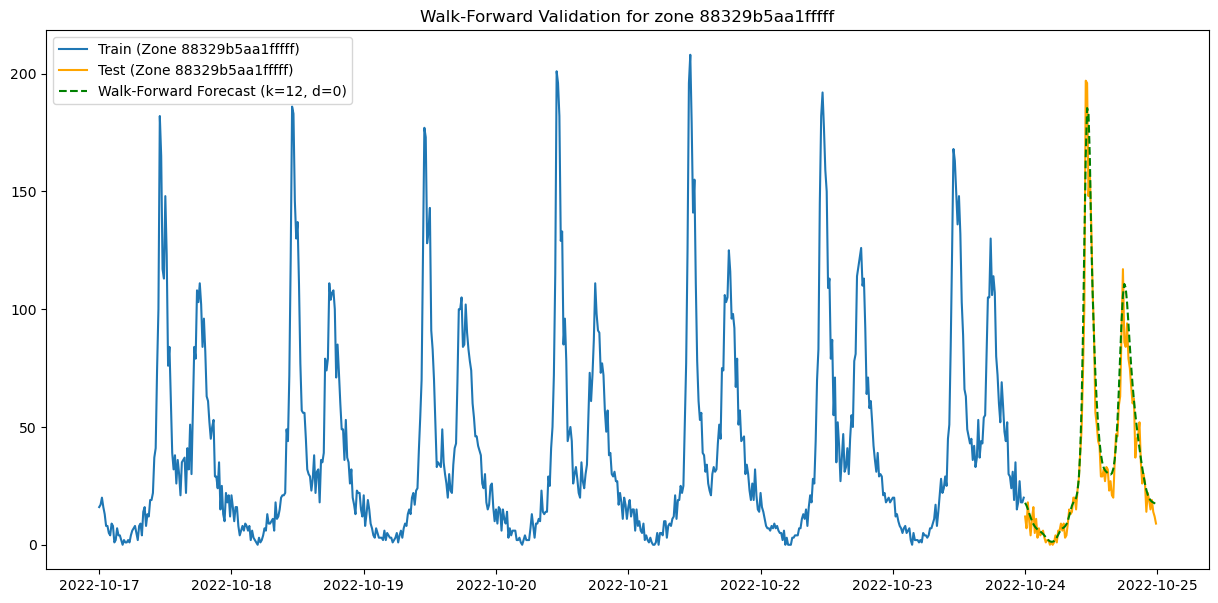

In [ ]:
#For our target zone for comparison
target_zone_id = '88329b5aa1fffff'

if target_zone_id in results:
    plt.figure(figsize=(15, 7))
    #Train data
    plt.plot(pivot_data.index[:split_point_idx],
             pivot_data[target_zone_id].iloc[:split_point_idx],
             label=f'Train (Zone {target_zone_id})')
    #Test data
    plt.plot(pivot_data.index[split_point_idx:],
             results[target_zone_id]['actual'],
             label=f'Test (Zone {target_zone_id})', color='orange')
    #Predictions
    plt.plot(pivot_data.index[split_point_idx:],
             results[target_zone_id]['predictions'],
             label=f'Walk-Forward Forecast (k={k}, d=0)', color='green', linestyle='--')
    plt.title(f'Walk-Forward Validation for zone {target_zone_id}')
    plt.legend()
    plt.show()

    # Export as numpy array for comparison
    predictions_to_export = results[target_zone_id]['predictions']
    export_filename = 'prognose_arima.npy' # Fixed filename
    np.save(export_filename, predictions_to_export)

else:
    print(f'Zone not found: This is a list of valid zones:  {list(results.keys())}')